In [1]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

import csv
from data_preparation  import preprocess_field_data, prepro_data_kl
from hsic import HSIC
import json
import matplotlib.pyplot as plt
from mcmc_integration import BayesCalibrationMCMC
from metamodels import VPCEMetamodel, KarhunenLoeveMetamodel, GpMetamodelInd
import numpy as np
import openturns as ot
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
from plot import plot_tpd


BASE_DIRECTORY = '/Users/edgarjaber/Desktop/Articles/codes folder/Bayes-calibration-for-clogging-prognostics/DATA/'
SIMULATION_TIME = np.load(BASE_DIRECTORY + 'simulation_data/LHS/d8/t_gv.npy', allow_pickle=True)

csv_file = BASE_DIRECTORY + 'field_data/field_data.csv'
input_dic = json.load(open(BASE_DIRECTORY + 'meta_data/SG_cleaning_conditioning.json'))
cleaning_dates = [input_dic['chemistry']['cleaning'][i]['time']/24 for i in range(len(input_dic['chemistry']['cleaning']))]

plt.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True

In [2]:
def kl_div(a, b):
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

# Methodology implementation

In [3]:
mc_hl = np.load(BASE_DIRECTORY + 'simulation_data/MC/d8/doe_hl.npy', allow_pickle=True)
mc_cl = np.load(BASE_DIRECTORY + 'simulation_data/MC/d8/doe_cl.npy', allow_pickle=True)

n_max = mc_hl.shape[0]
n_samp = 1000
input_dimension = 8


In [9]:
#Base metamodel
X, y, SCALER = prepro_data_kl(mc_hl, mc_cl, n_max, n_samp, input_dimension, scale=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)
GP = GpMetamodelInd(trend='Constant', kernel='AbsExp', input_dimension=(input_dimension-1))
full_metamodel = KarhunenLoeveMetamodel(metamodel=GP, input_dimension=input_dimension, simulation_time=SIMULATION_TIME)
full_metamodel.fit(X_train, y_train)

11 nan trajectories in output sample
Running Karhunen-Loeve decomposition
Explained variance for 2 modes is 0.999998157762496
Done fitting mode 1
Done fitting mode 2


In [6]:
r2_score = full_metamodel.r2_score(X_test, y_test, SIMULATION_TIME)

In [5]:
#Individual variable scalers
x, _ = prepro_data_kl(mc_hl, mc_cl, n_max, n_samp, input_dimension, scale=False)
scalers = []
for i in range(x.shape[1]):
    scaler = StandardScaler()
    scaler.fit(x[:,i].reshape(-1,1))
    scalers.append(scaler)

11 nan trajectories in output sample


In [6]:
#Prior distributions
alpha = ot.Uniform(100.0, 103.0)
beta = ot.Uniform(0.02, 0.025)
eps_e = ot.Uniform(0.2, 0.5)
eps_c = ot.Uniform(0.01, 0.3)
d_p = ot.Uniform(0.5e-6, 10.0e-6)
g_p0 = ot.Uniform(1.0e-9, 8.0e-9)
a_v = ot.Uniform(0.0, 15e-4)

marginals = [alpha, beta, eps_e, eps_c, d_p, g_p0, a_v]

prior = ot.ComposedDistribution(marginals)

In [7]:
data_without_time_division, _ = preprocess_field_data(csv_file=csv_file, 
                                operation_time=SIMULATION_TIME, 
                                cleaning_dates=cleaning_dates, 
                                with_time_division=False)

data_with_time_division, time_indices = preprocess_field_data(csv_file=csv_file,
                                operation_time=SIMULATION_TIME, 
                                cleaning_dates=cleaning_dates, 
                                with_time_division=True)

In [ ]:
threshold = 1e-7
N = 10000

#Metamodels 
TRENDS = ['Constant', 'Linear', 'Quad']
COVS = ['AbsExp', 'SqExp', 'M-1/2', 'M-3/2', 'M-5/2']

#MCMC parameters
step_sizes = [10, 0.01, 0.01, 0.05, 5e-6, 1.5e-9, 1e-3]
proposal_distribution = [ot.Uniform(-step, step) for step in step_sizes]

posterior_distributions = []

ot.RandomGenerator.SetSeed(42)
for i in range(3):

    #reset the prior distribution
    X, y, SCALER = prepro_data_kl(mc_hl, mc_cl, n_max, n_samp, input_dimension, scale=True)
    marginals = [alpha, beta, eps_e, eps_c, d_p, g_p0, a_v]
    x, _ = prepro_data_kl(mc_hl, mc_cl, n_max, n_samp, input_dimension, scale=False)
    scalers = []
    for k in range(x.shape[1]):
        scaler = StandardScaler()
        scaler.fit(x[:,k].reshape(-1,1))
        scalers.append(scaler)

    print('Starting assimilation for CC cycle ', i+1)

    while True:

        y_interpolated = np.asarray([np.interp(data_without_time_division[:,0]*24, SIMULATION_TIME*24, y[i,:]) for i in range(len(y))])

        X_train, X_test, y_train_int, y_test_int = train_test_split(X, y_interpolated, train_size=0.75, random_state=42)

        #Compute the max HSIC index
        hsic = HSIC(ot.Sample(X), ot.Sample(y))
        r2_hsic, _ = hsic.r2_hsic()
        index = int(np.where(max(r2_hsic.mean(axis=1)) == r2_hsic.mean(axis=1))[0][0])
        print('HSIC max is for index = ', (index+1))

        # Compute all the calibration metamodels
        print('Computing calibration metamodels')
        metamodels = []
        for trend in TRENDS:
            for cov in COVS:
                GP = GpMetamodelInd(trend=trend, kernel=cov, input_dimension=(input_dimension-1), index=index)
                KL_calibration = KarhunenLoeveMetamodel(metamodel=GP, input_dimension=input_dimension, simulation_time=data_without_time_division[:,0]*24, verbose=False)
                KL_calibration.fit(X_train, y_train_int)
                metamodels.append(KL_calibration)

        # GP scalers for the index variable
        all_scalers = [scalers[int(index)]]*(len(metamodels))

        # MCMC posterior distribution
        print('Running MCMC calibration')
        bayes_int = BayesCalibrationMCMC(data=data_with_time_division[i], data_time_indices=time_indices[i], metamodels=metamodels, scalers=all_scalers)

        posterior = bayes_int.mcmc_run(support_min=[marginals[index].getRange().getLowerBound()[0]], support_max=[marginals[index].getRange().getUpperBound()[0]], proposal=proposal_distribution[index], burning=100, n_chains=3, sample_size=1000, nb_weights=1000)

        # Compute the Kullback divergence
        posterior_samples = np.asarray(posterior.getSample(N)).reshape(-1)
        prior_samples = np.asarray(marginals[index].getSample(N)).reshape(-1)

        posterior_pdf, _ = np.histogram(posterior_samples, bins=100, density=True)
        prior_pdf, _ = np.histogram(prior_samples, bins=100, density=True)

        posterior_pdf = posterior_pdf / np.sum(posterior_pdf)
        prior_pdf = prior_pdf / np.sum(prior_pdf)

        kullback_divergence = kl_div(posterior_pdf, prior_pdf)
        print('Kullback-Leibler divergence = ', kullback_divergence)

        if kullback_divergence < threshold or kullback_divergence == np.inf:
            #the prior is fully informed by the data and the calibration is stopped
            posterior_distributions.append(marginals)
            break

        elif kullback_divergence > threshold:
            #modify the prior distribution
            marginals[index] = posterior
            prior = ot.ComposedDistribution(marginals)
            X = np.asarray(prior.getSample(n_max))
            #Update the scalers
            scalers = []
            for k in range(X.shape[1]):
                scaler = StandardScaler()
                scaler.fit(X[:,k].reshape(-1,1))
                scalers.append(scaler)
            #Update the design of experiments
            X = SCALER.transform(X)
            y = full_metamodel.predict(X)
            continue

11 nan trajectories in output sample
11 nan trajectories in output sample
Starting assimilation for CC cycle  1
HSIC max is for index =  7
Computing calibration metamodels


WRN - (previous message repeated 8 times)
WRN - TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0000603779409774
Kullback-Leibler divergence =  1.5212754698955684


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  6
Computing calibration metamodels


WRN - (previous message repeated 7 times)
WRN - Warning! For coherency we set scale upper bounds = [6.85096,6.8249,6.96702,7.00471,6.83626,6.90782,3.15954]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0013888662355448
Kullback-Leibler divergence =  1.288810697289675


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  5
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.9214,6.81031,6.97207,7.02377,6.79716,5.75979,2.21828]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 0.9990242633340076
Kullback-Leibler divergence =  0.32870447823098314


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  4
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.92665,6.82286,6.97529,7.00455,3.11591,4.76859,2.45442]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 0.9992634429189257
Kullback-Leibler divergence =  0.5695860980549527


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  2
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.90728,6.81279,6.97814,4.8173,2.9417,5.60212,4.62787]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 0.9998093834717444
Kullback-Leibler divergence =  0.2536585268825114


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  7
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.88119,6.79806,6.9619,6.47241,2.87985,5.60212,3.01634]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 0.9993645253888018
Kullback-Leibler divergence =  inf
11 nan trajectories in output sample
11 nan trajectories in output sample
Starting assimilation for CC cycle  2


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  7
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]
WRN - (previous message repeated 6 times)
WRN - TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0067996296345065
Kullback-Leibler divergence =  0.9169596146508138


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  6
Computing calibration metamodels


WRN - (previous message repeated 7 times)
WRN - Warning! For coherency we set scale upper bounds = [6.91174,6.80593,6.96705,7.02907,6.81739,6.9157,1.49079]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0005510384472527
Kullback-Leibler divergence =  0.34348838613376237


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  5
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.89733,6.82874,6.97423,7.0274,6.83711,5.43528,1.49079]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0004000196216725
Kullback-Leibler divergence =  0.38071183075377596


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  4
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.92248,6.7976,6.96217,7.01699,5.01512,5.44203,1.49079]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.000026350386013
Kullback-Leibler divergence =  0.2506895115614106


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  7
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.89056,6.8273,6.95423,6.9246,4.56063,5.44203,2.02694]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 0.9992904432520219
Kullback-Leibler divergence =  inf
11 nan trajectories in output sample
11 nan trajectories in output sample
Starting assimilation for CC cycle  3


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  7
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]
WRN - (previous message repeated 6 times)
WRN - TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0065027492682255
Kullback-Leibler divergence =  2.042786401199279


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  4
Computing calibration metamodels


WRN - (previous message repeated 7 times)
WRN - Warning! For coherency we set scale upper bounds = [6.92101,6.81843,6.96324,7.02882,6.81219,6.90872,3.21292]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0064765138762597
Kullback-Leibler divergence =  0.2518471099225996
HSIC max is for index =  6
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.92206,6.80929,6.94014,6.91551,6.82058,6.92354,3.09273]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 0.999186544412285
Kullback-Leibler divergence =  0.2764055769566295


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  5
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.91091,6.82689,6.94299,6.91944,6.84249,5.99713,3.21292]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0003309275298493
Kullback-Leibler divergence =  0.4666516353363577


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  4
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.91663,6.81602,6.94475,6.73025,6.16621,6.21592,2.84493]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0088854724711638
Kullback-Leibler divergence =  0.47418847065789427


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  6
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.9006,6.7842,6.95245,5.93092,6.60951,5.84038,3.21115]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0040569678135391
Kullback-Leibler divergence =  inf


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


# Results visualization

In [19]:
N = 10000
trajs = []
for i in range(3): 
    trajs.append(full_metamodel.predict(SCALER.transform(ot.ComposedDistribution(posterior_distributions[i]).getSample(N))))

In [20]:
nc1 = np.where((SIMULATION_TIME*24).astype(int) == 150792)[0][0]
nc2 = np.where((SIMULATION_TIME*24).astype(int) == 221928)[0][0]

In [21]:
traj = np.concatenate((trajs[0][:,:nc1+1], np.concatenate((trajs[1][:,nc1+1:nc2+1], trajs[2][:,nc2+1:]), axis=1)), axis=1)

In [22]:
marginals = [alpha, beta, eps_e, eps_c, d_p, g_p0, a_v]
traj_prior = full_metamodel.predict(SCALER.transform(ot.ComposedDistribution(marginals).getSample(N)))

Text(0.5, 0.98, 'TPD simulations with prior distributions and after assimilation')

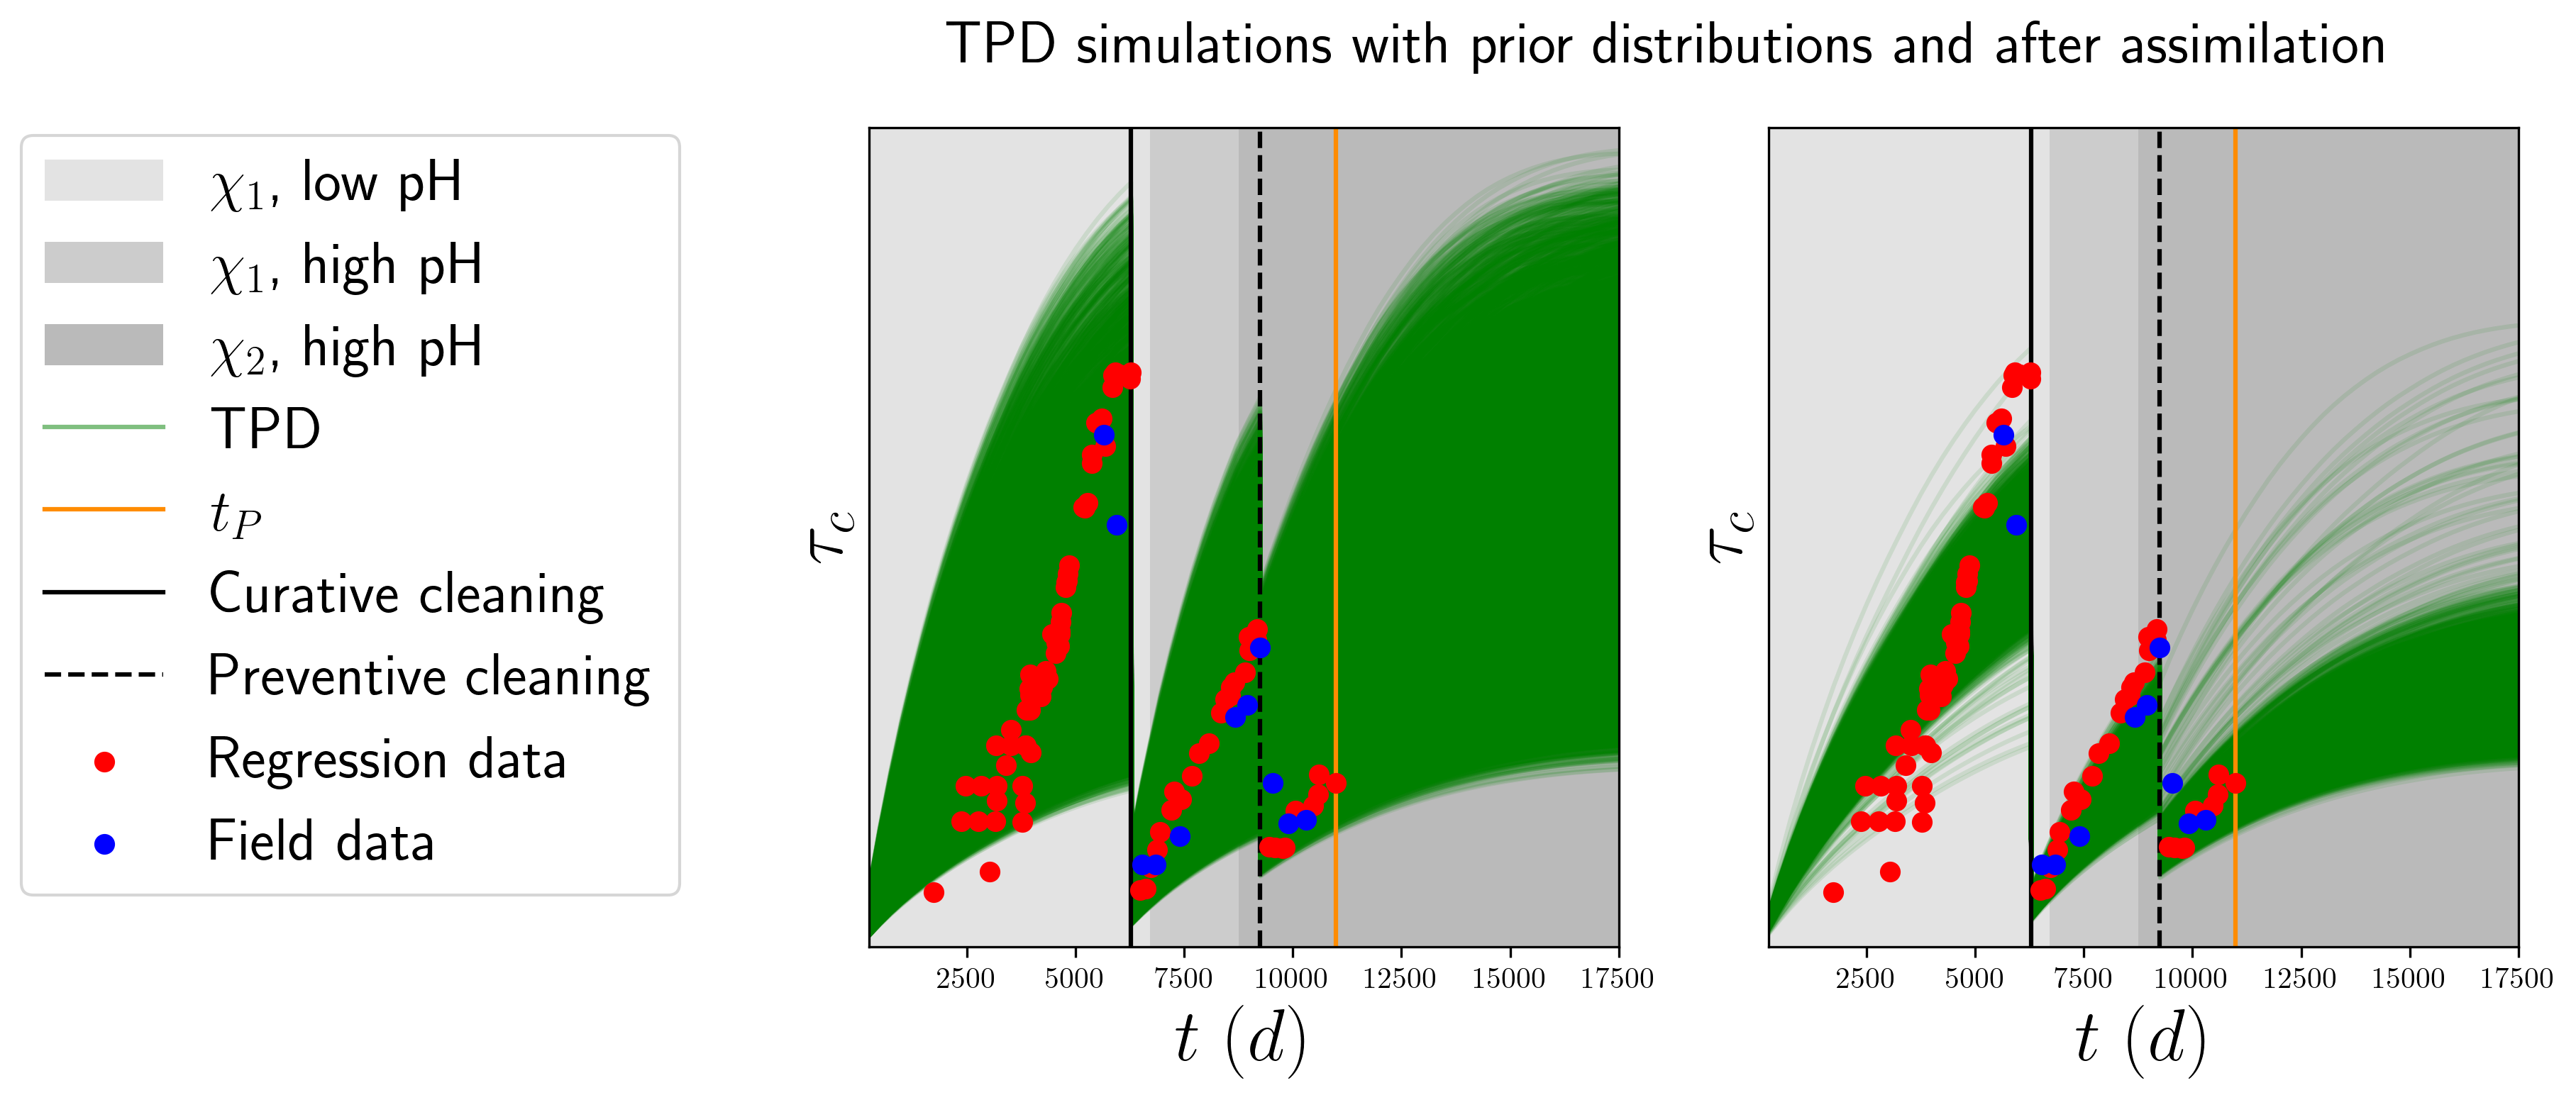

In [23]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0] = plot_tpd(axs[0], input_dic, traj_prior, SIMULATION_TIME, 'TPD')
axs[1] = plot_tpd(axs[1], input_dic, traj, SIMULATION_TIME, 'TPD')

for i in range(3):
    if i == 0:
        axs[0].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red', label='Regression data', zorder=10)
        axs[0].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', label='Field data', zorder=10)
        axs[1].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red', zorder=10)
        axs[1].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', zorder=10)
    else:
        axs[0].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red',  zorder=10)
        axs[0].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', zorder=10)
        axs[1].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red', zorder=10)
        axs[1].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', zorder=10)

axs[0].grid(False)
axs[1].grid(False)

axs[0].set_yticks([])
axs[1].set_yticks([])

lines_labels = [axs[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.05,0.9), fontsize=20)

fig.suptitle(r'TPD simulations with prior distributions and after assimilation', fontsize=20)

In [ ]:
posterior_distrib_dfs = []
for i in range(3):
    posterior_samples = np.asarray([np.asarray(posterior_distributions[i][j].getSample(1000)).reshape(-1) for j in range(len(posterior_distributions[i]))])
    posterior_distrib_df = pd.DataFrame(posterior_samples.T, columns=['X'+str(j) for j in range(1,8)])
    posterior_distrib_dfs.append(posterior_distrib_df)

In [27]:
with open('posterior_distrib_dfs.pkl', 'wb') as f:
    pickle.dump(posterior_distrib_dfs, f)

In [ ]:
with open('posterior_distrib_dfs.pkl', 'rb') as f:
    posterior_distrib_dfs = pickle.load(f)

In [49]:
df_x1 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X1'], 'CC-PC': posterior_distrib_dfs[1]['X1'], 'PC': posterior_distrib_dfs[2]['X1']})
df_x2 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X2'], 'CC-PC': posterior_distrib_dfs[1]['X2'], 'PC': posterior_distrib_dfs[2]['X2']})
df_x3 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X3'], 'CC-PC': posterior_distrib_dfs[1]['X3'], 'PC': posterior_distrib_dfs[2]['X3']})
df_x4 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X4'], 'CC-PC': posterior_distrib_dfs[1]['X4'], 'PC': posterior_distrib_dfs[2]['X4']})
df_x5 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X5'], 'CC-PC': posterior_distrib_dfs[1]['X5'], 'PC': posterior_distrib_dfs[2]['X5']})
df_x6 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X6'], 'CC-PC': posterior_distrib_dfs[1]['X6'], 'PC': posterior_distrib_dfs[2]['X6']})
df_x7 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X7'], 'CC-PC': posterior_distrib_dfs[1]['X7'], 'PC': posterior_distrib_dfs[2]['X7']})
dfs = [df_x1, df_x2, df_x3, df_x4, df_x5, df_x6, df_x7]

/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/4027938685.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i//4, i%4].legend().set_visible(False)
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/4027938685.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i//4, i%4].legend().set_visible(False)
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/4027938685.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i//4, i%4].legend().set_visible(False)
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_66510/4027938685.py:11: UserWarning: No artists

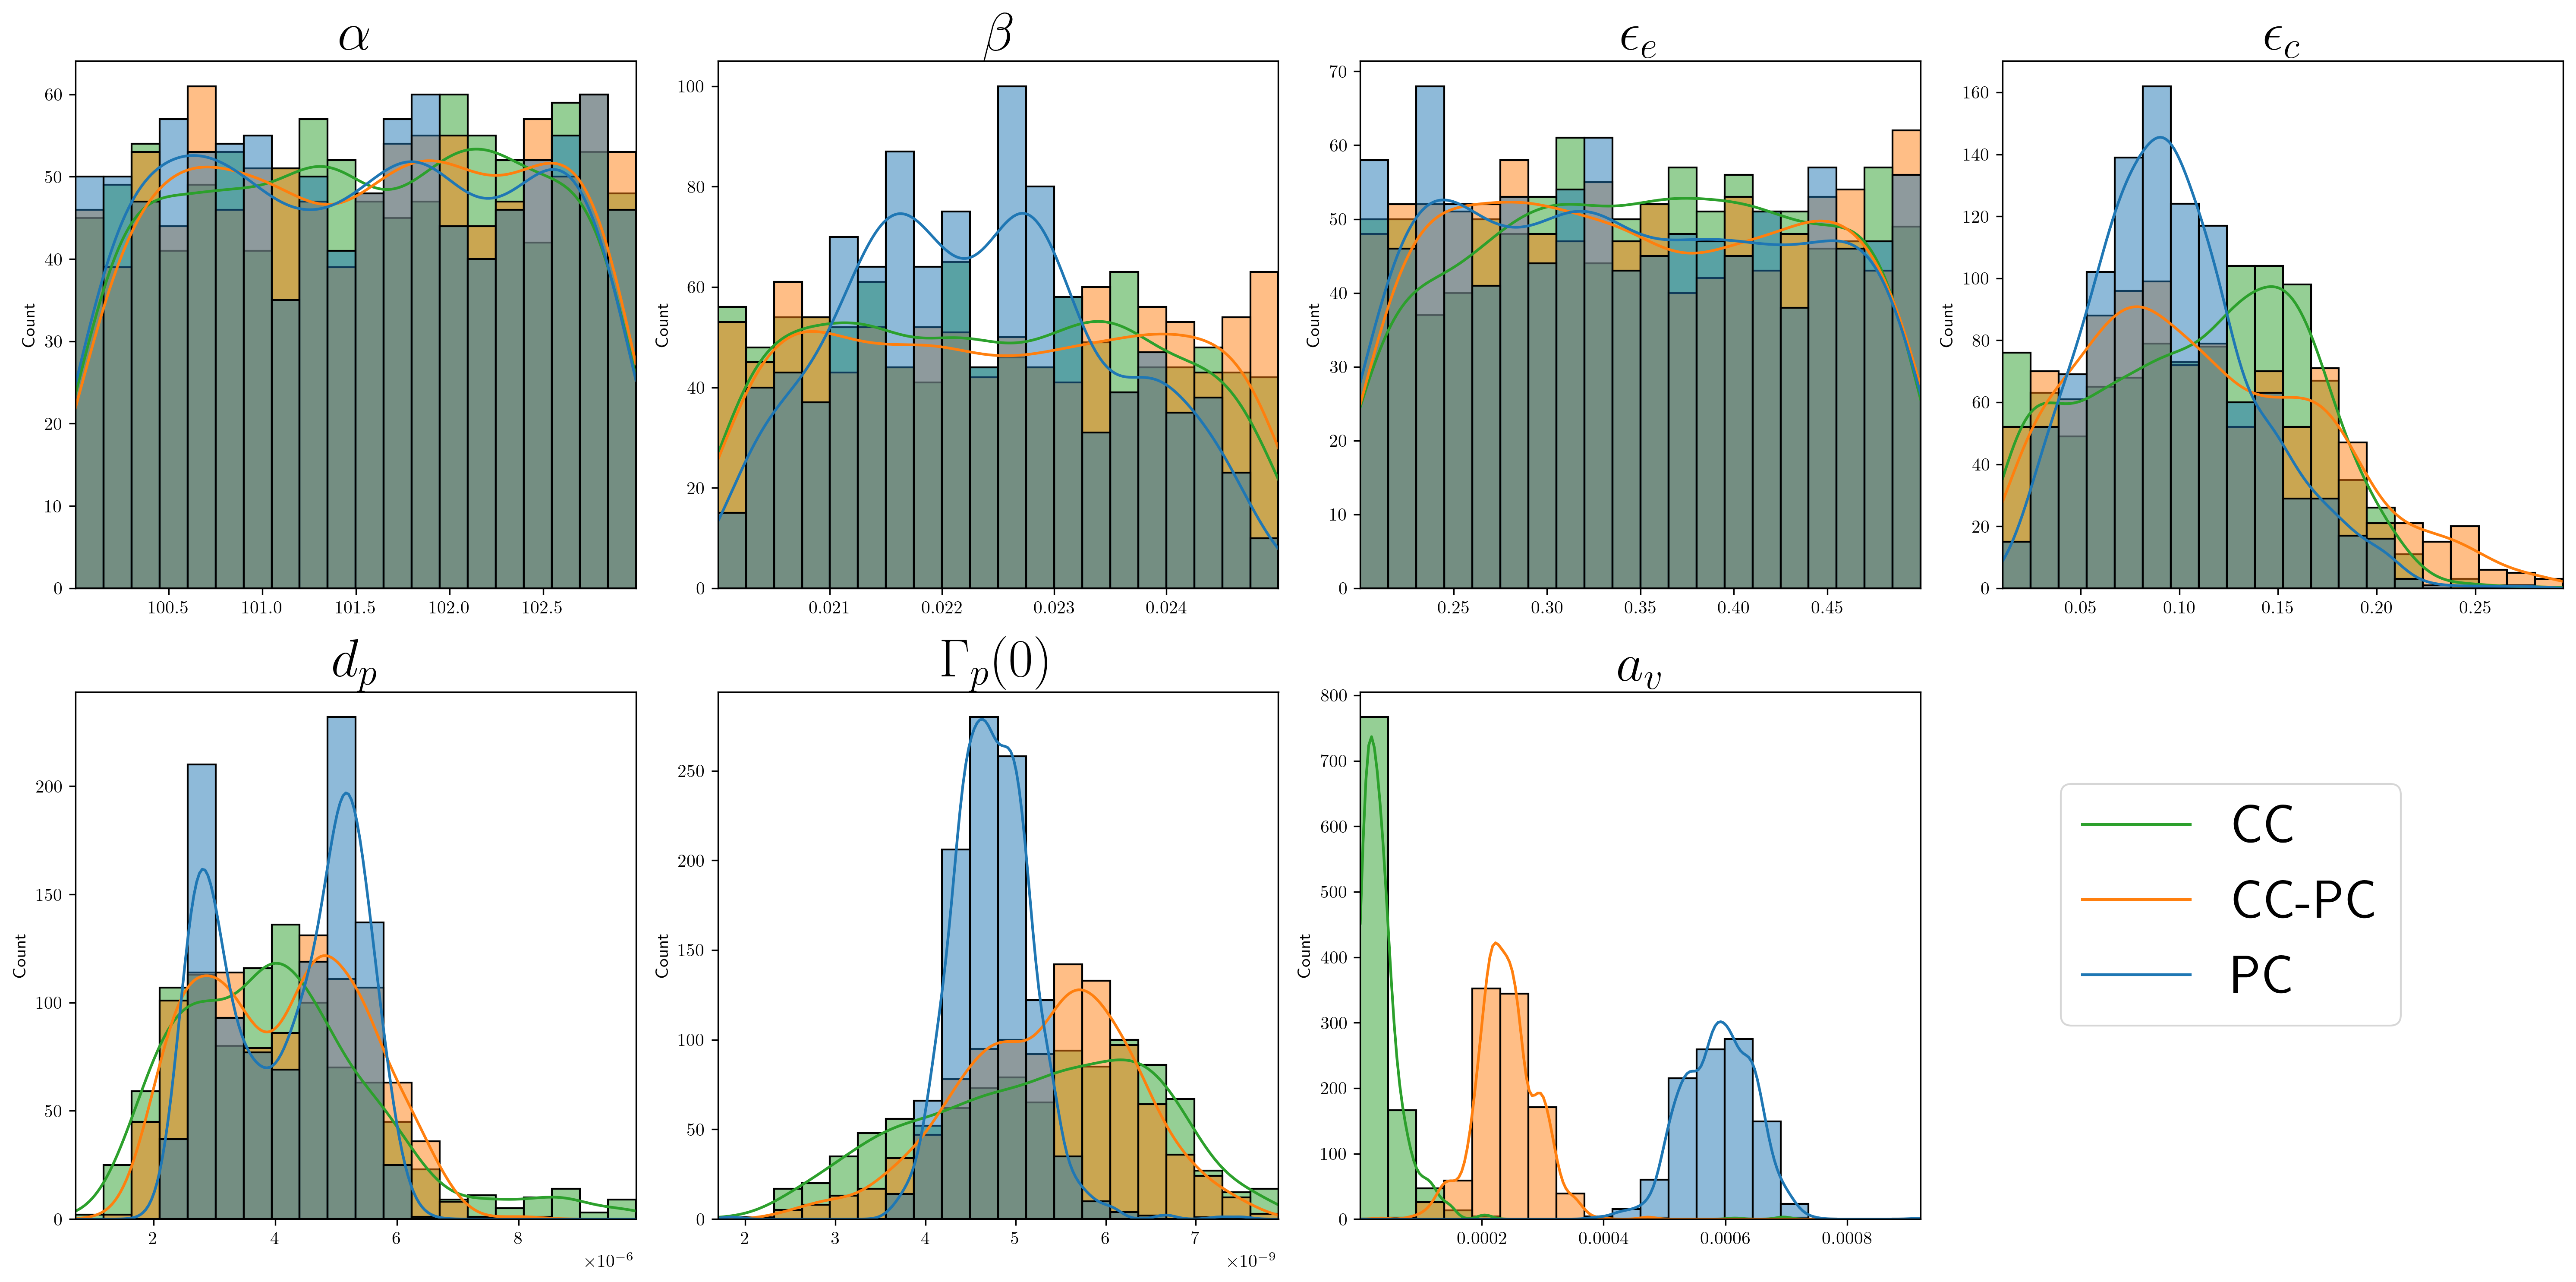

In [71]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))
label = ['CC', 'CC-PC', 'PC']
titles = [r"$\alpha$", r"$\beta$", r"$\epsilon_e$", r"$\epsilon_c$", r"$d_p$", r"$\Gamma_{p}(0)$", r"$a_v$"]

for i in range(7):
    sns.histplot(dfs[i], ax=axs[i//4, i%4], bins=20, kde=True)
    axs[i//4, i%4].set_title(titles[i], fontsize=30)
    axs[i//4, i%4].set_xlabel('')
    #axs[i//4, i%4].set_ylabel('')
    #axs[i//4, i%4].set_yticks([])
    axs[i//4, i%4].legend().set_visible(False)
    axs[i//4, i%4].set_xlim(dfs[i].min().min(), dfs[i].max().max())
fig.legend(labels=label, loc=(0.8,0.2), fontsize=30)
fig.delaxes(axs[1, 3])
plt.tight_layout()